# Intelligence Report: Exploratory Data Analysis (Active Environment)
**Project:** Orbital Clutter: Mapping the Kessler Acceleration  
**Dataset:** `ucs_cleaned.csv` (Active Satellite Population)  
**Analyst:** James Glosser  

---

### **The Analytical Strategy**
Before modeling the collision probability of the debris field, we must establish a baseline of the **Active Population**. This notebook characterizes the "Target Environment" across three dimensions:

1.  **Mass Profiling:** Identifying "High-Value" targets versus the swarm (Starlink/CubeSats) to understand kinetic potential.
2.  **Stakeholder Analysis:** Quantifying the shift from State-Actor dominance to Commercial proliferation.
3.  **Temporal Dynamics:** Modeling the velocity of "New Space" launches to determine the acceleration rate.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit, brentq

# Visual Architecture: Orbital Dashboard ---
# Set the Palette (High Contrast Neon)
sns.set_palette("plasma") 

# Set the Background (Deep Space Black)
plt.style.use('dark_background')

# Force Overrides for "True Black" and readability
plt.rcParams.update({
    "grid.alpha": 0.2,            # Faint, non-intrusive grid
    "axes.facecolor": "black",    # No grey haze in plot area
    "figure.facecolor": "black",  # No grey haze in outer area
    "text.color": "white",        # High contrast text
    "axes.labelcolor": "white",   # Axis labels
    "xtick.color": "white",       # Ticks
    "ytick.color": "white",
    "legend.facecolor": "black",  # Legend background
    "legend.edgecolor": "white"   # Legend border
})

print("Environment Initialized: Visual Systems Online.")

Environment Initialized: Visual Systems Online.


In [2]:
# Load the "Deep Scrub" Dataset
# We parse dates immediately to enable the Temporal Analysis later
ucs_cleaned = pd.read_csv('../../data/clean/ucs_cleaned.csv', parse_dates=['launch_date'])

# Mission Status Check
print(f"Active Fleet Registry Synchronized: {len(ucs_cleaned)} operational assets validated.")
print(f"Data Schema: {ucs_cleaned.shape[1]} features available.")

Active Fleet Registry Synchronized: 7542 operational assets validated.
Data Schema: 34 features available.


### Data Pre-Processing: Feature Engineering
**Objective:** Standardize categorical features for aggregation.
* **Orbit Regimes:** Compressing sub-classes into the "Big Three" (`LEO`, `MEO`, `GEO`) to map the Kessler Canyon.

In [3]:
# Extract Launch Year
ucs_cleaned['launch_year'] = ucs_cleaned['launch_date'].dt.year

# We map the complex registry into the "Big Three" risk zones (Regimes).
# Anything that isn't LEO, MEO, or GEO gets tagged as "Other".
target_orbits = ['LEO', 'MEO', 'GEO']
ucs_cleaned['orbit_regime'] = ucs_cleaned['orbit_class'].apply(lambda x: x if x in target_orbits else 'Other')

# Integrity Check
# Verify the new 'orbit_regime' column
print(f"Features Verified: 'launch_year' is present.")
print(f"Regime Standardization: {ucs_cleaned['orbit_regime'].value_counts().to_dict()}")

Features Verified: 'launch_year' is present.
Regime Standardization: {'LEO': 6750, 'GEO': 590, 'MEO': 143, 'Other': 59}


## Section 1.0: Kinetic Mass Profiling
**The Objective:** Visualize the distribution of mass in orbit. In a collision event, mass equates to "shrapnel potential." We must distinguish between the "Swarm" (low mass, high count) and the "Heavy Hitters" (high mass, low count).

**The Methodology:**
* **Logarithmic Scaling:** Applied to `launch_mass_kg` to account for the disparity between CubeSats (<10 kg) and the **International Space Station (450,000 kg)**.
* **White Whale Logic:** Explicitly handling the ISS outlier to prevent visualization compression.

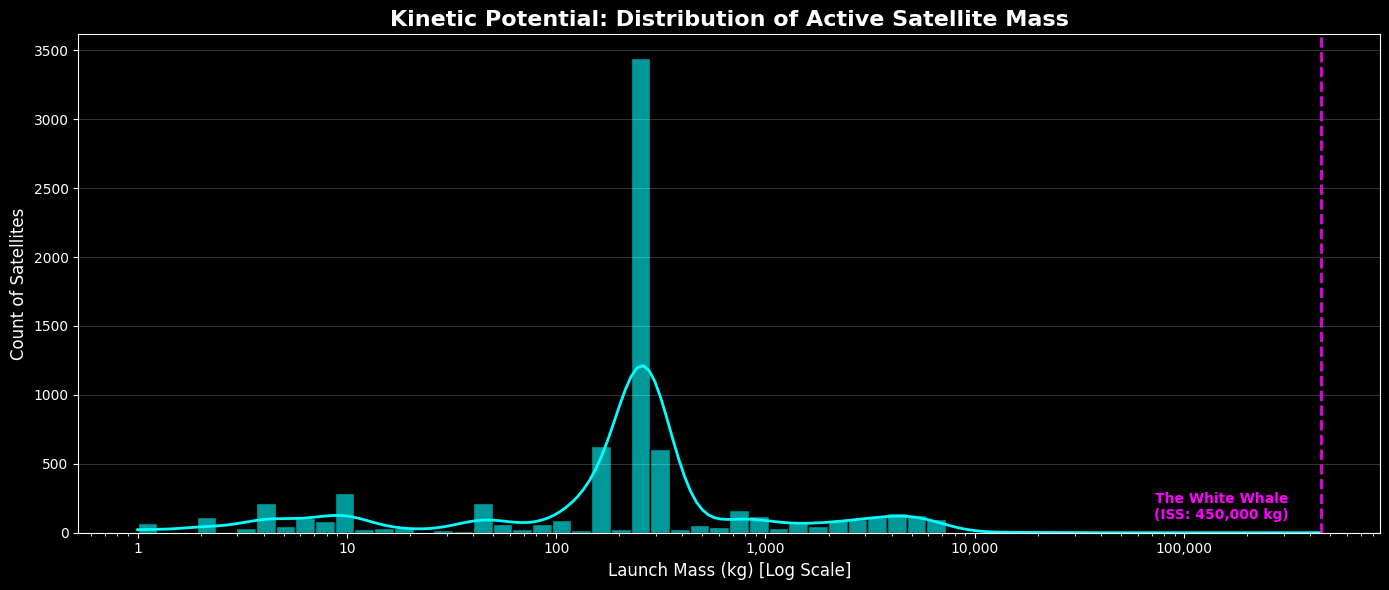

--- Mass Profile Statistics (kg) ---
count      7542.000000
mean        690.293821
std        5358.470524
min           1.000000
25%         148.000000
50%         260.000000
75%         280.000000
max      450000.000000
Name: launch_mass_kg, dtype: object


In [4]:
plt.figure(figsize=(14, 6))

# The Histogram (The Swarm vs. The Heavy Hitters)
# We use log_scale=True because the range [1kg ... 450,000kg] is extremely wide for linear plots
sns.histplot(ucs_cleaned['launch_mass_kg'], kde=True, bins=60, log_scale=True, 
             color='cyan', edgecolor='black', alpha=0.6, line_kws={'linewidth': 2})

# The "White Whale" Annotation (ISS)
# We highlight the ISS specifically because it represents the single largest collision risk
iss_mass = 450000
plt.axvline(iss_mass, color='magenta', linestyle='--', linewidth=2, alpha=0.9)
plt.text(iss_mass * 0.7, 100, f'The White Whale\n(ISS: {iss_mass:,} kg)', 
         color='magenta', ha='right', fontweight='bold')

# Formatting the Axis to be easier to read. Average people can't visualize/conceptualize what "10^5 kg (100,000 kg)" represents.

# Get current axis
ax = plt.gca()

# This function converts "10^3" -> "1,000" for instant readability
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Standard Labels (Space Theme)
plt.title('Kinetic Potential: Distribution of Active Satellite Mass', fontsize=16, color='white', fontweight='bold')
plt.xlabel('Launch Mass (kg) [Log Scale]', fontsize=12, color='white')
plt.ylabel('Count of Satellites', fontsize=12, color='white')
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

# 5. Statistical Audit
print("--- Mass Profile Statistics (kg) ---")
print(ucs_cleaned['launch_mass_kg'].describe().apply(lambda x: format(x, 'f')))

## Section 1.5: Orbital Topography (The Kessler Canyon)
**The Objective:** Map the physical distribution of assets to identify the "Kessler Canyon"—the altitude bands with the highest density of collision targets.

**The Insight:**
Mass is not evenly distributed. The **Scatter Analysis** below reveals that the "Swarm" (low mass) is concentrating in Low Earth Orbit (LEO), while legacy heavy platforms dominate Geosynchronous Orbit (GEO).

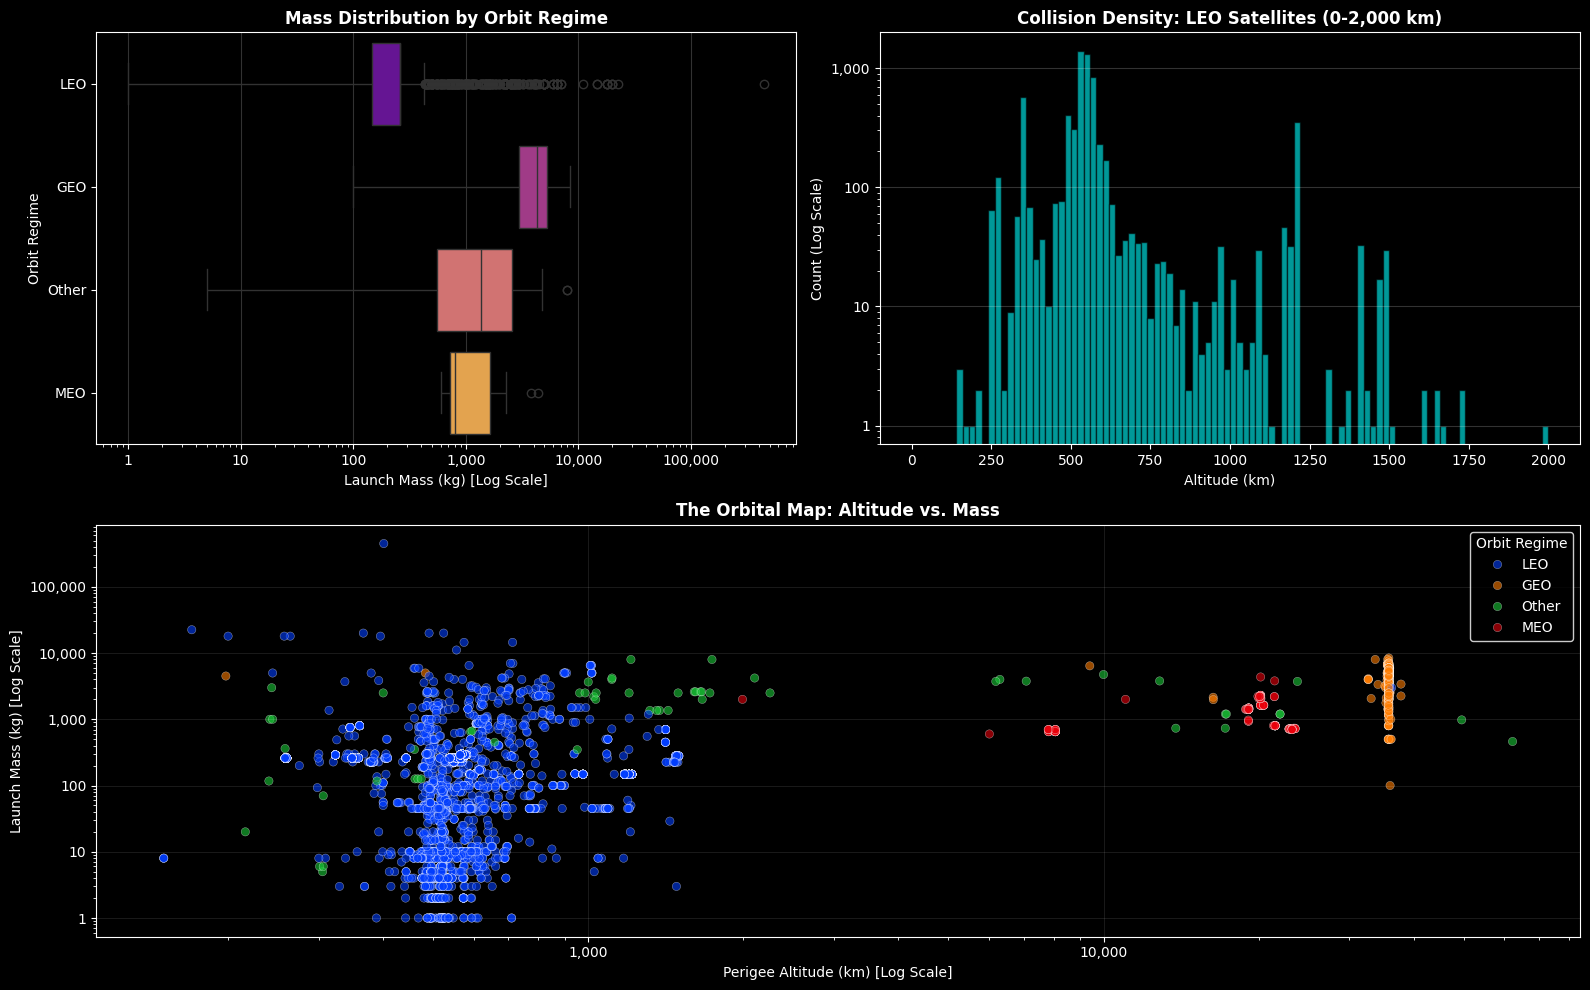

In [5]:
plt.figure(figsize=(16, 10))

# Plot A: Mass vs. Orbit Regime (The Weight of Regimes)
plt.subplot(2, 2, 1)
sns.boxplot(data=ucs_cleaned, x='launch_mass_kg', y='orbit_regime', hue='orbit_regime', palette='plasma', legend=False)
plt.xscale('log')

# Formatting the Axis to be easier to read. Average people can't visualize/conceptualize what 10(^n) represents.
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.title('Mass Distribution by Orbit Regime', color='white', fontweight='bold')
plt.xlabel('Launch Mass (kg) [Log Scale]', color='white')
plt.ylabel('Orbit Regime', color='white')
plt.grid(axis='x', alpha=0.2)


# Plot B: The Kessler Canyon (Altitude Density)
plt.subplot(2, 2, 2)

# We limit to 2,000km to focus on the LEO congestion point
plt.hist(ucs_cleaned['perigee_km'], bins=100, range=(0, 2000), color='cyan', alpha=0.6, edgecolor='black')
plt.yscale('log')

# Format Y-axis to standard numbers
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.title('Collision Density: LEO Satellites (0-2,000 km)', color='white', fontweight='bold')
plt.xlabel('Altitude (km)', color='white')
plt.ylabel('Count (Log Scale)', color='white')
plt.grid(axis='y', alpha=0.2)


# Plot C: The Orbital Map (Altitude vs. Mass)
plt.subplot(2, 1, 2)
sns.scatterplot(data=ucs_cleaned, x='perigee_km', y='launch_mass_kg', hue='orbit_regime', 
                palette='bright', alpha=0.6, edgecolor='white', linewidth=0.3)
plt.yscale('log')
plt.xscale('log')

# Format BOTH axes to standard numbers for maximum readability
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.title('The Orbital Map: Altitude vs. Mass', color='white', fontweight='bold')
plt.xlabel('Perigee Altitude (km) [Log Scale]', color='white')
plt.ylabel('Launch Mass (kg) [Log Scale]', color='white')
plt.grid(True, alpha=0.1)
plt.legend(title='Orbit Regime', facecolor='black', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

## Section 2.0: Stakeholder Architecture
**The Objective:** Quantify the shift from State-Actor dominance to Commercial proliferation.

**The Transition:**
* **Old Space (Pre-2012):** A domain reserved for superpowers (USA, Russia, China).
* **New Space (Post-2012):** The explosion of commercial entities. The visualizations below highlight this inversion of control.

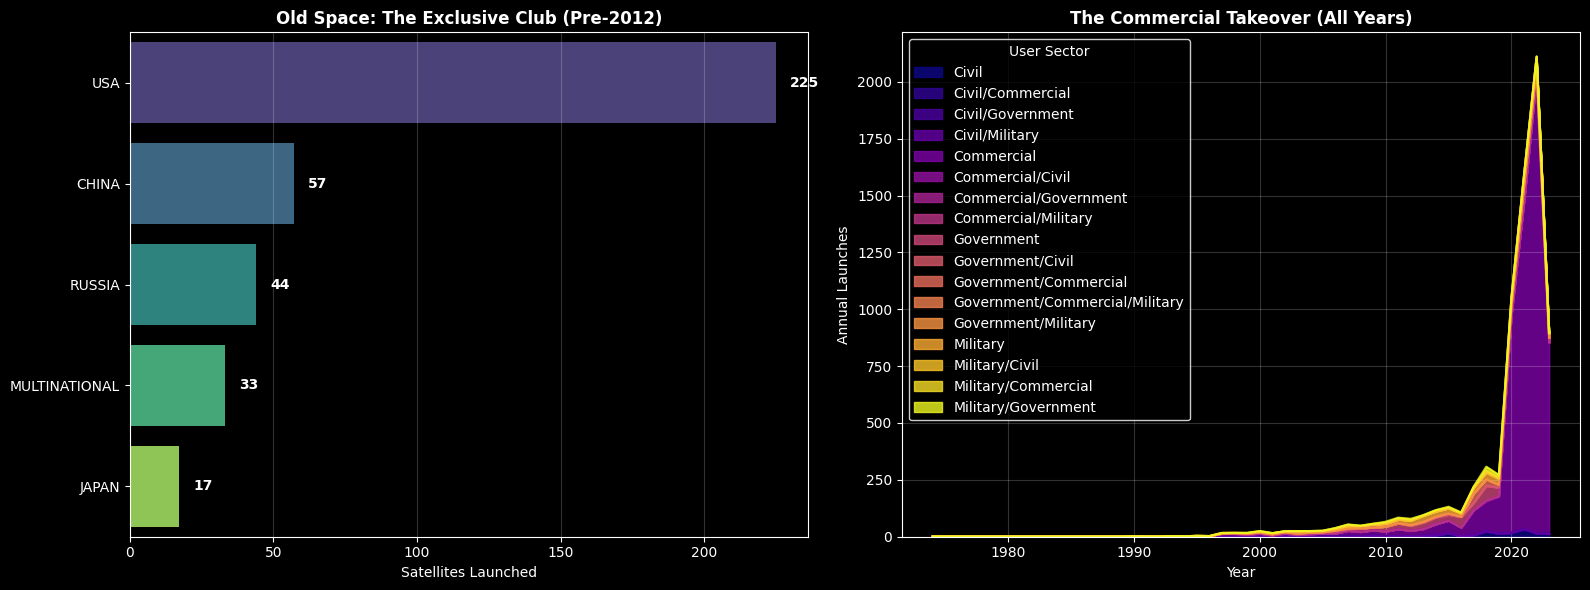

In [6]:
# Old Space (Pre-2012)
old_space = ucs_cleaned[ucs_cleaned['launch_year'] < 2012]
country_counts = old_space['country_operator'].value_counts().head(5)

plt.figure(figsize=(16, 6))

# Plot A: The "Old Space" Club (Pre-2012)
plt.subplot(1, 2, 1)

# Using 'viridis' to distinguish the state actors
sns.barplot(x=country_counts.values, y=country_counts.index, hue=country_counts.index, palette='viridis', legend=False)

plt.title('Old Space: The Exclusive Club (Pre-2012)', color='white', fontweight='bold')
plt.xlabel('Satellites Launched', color='white')

# Remove the Y label, the country names kind of explain themselfs.
plt.ylabel('')
plt.grid(axis='x', alpha=0.2)

# Annotate bars for clarity
for i, v in enumerate(country_counts.values):
    plt.text(v + 5, i, str(v), color='white', va='center', fontweight='bold')


# Plot B: The Commercial Explosion (Stacked Area)
plt.subplot(1, 2, 2)

# Create a pivot table: Year vs. User Type
# We use 'launch_year' created in the Feature Engineering step
sat_counts = ucs_cleaned.pivot_table(index='launch_year', columns='users', values='norad_id', aggfunc='count').fillna(0)

# Plotting the Area Chart
sat_counts.plot(kind='area', stacked=True, ax=plt.gca(), cmap='plasma', alpha=0.8)

plt.title('The Commercial Takeover (All Years)', color='white', fontweight='bold')
plt.ylabel('Annual Launches', color='white')
plt.xlabel('Year', color='white')
plt.grid(True, alpha=0.2)
plt.legend(title='User Sector', facecolor='black', edgecolor='white', labelcolor='white', loc='upper left')

plt.tight_layout()
plt.show()

## Section 3.0: Temporal Acceleration & Congestion
**The Objective:** Model the velocity of orbital population growth.

**The Congestion Point:**
As shown below, the exponential growth is not uniform. It is almost exclusively contained within the **Low Earth Orbit (LEO)** regime, creating a specific zone of high collision probability.

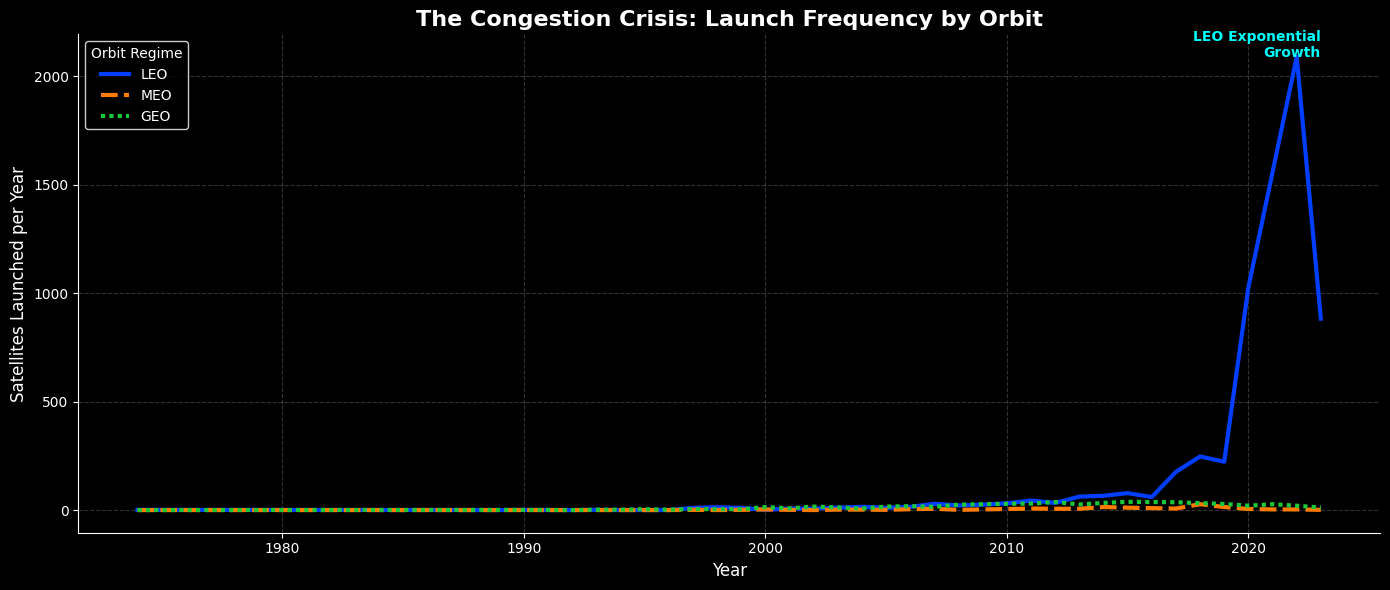

In [7]:
# Group by Year and Orbit Regime
# Build the pivot tabel using launch_year and orbit_regime
orbit_evolution = ucs_cleaned.pivot_table(
    index='launch_year', 
    columns='orbit_regime', 
    values='norad_id', 
    aggfunc='count'
).fillna(0)

# Filter for the Big Three to reduce noise
main_orbits = orbit_evolution[['LEO', 'MEO', 'GEO']]

plt.figure(figsize=(14, 6))

# Line Plot with "Neon" styling
# Using linewidth=3 to make the trends unmistakable against the black background
sns.lineplot(data=main_orbits, palette='bright', linewidth=3)

# Highlight the LEO Curve
plt.title('The Congestion Crisis: Launch Frequency by Orbit', fontsize=16, color='white', fontweight='bold')
plt.ylabel('Satellites Launched per Year', fontsize=12, color='white')
plt.xlabel('Year', fontsize=12, color='white')

# Grid and Legend
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend(title='Orbit Regime', facecolor='black', edgecolor='white', labelcolor='white')

# Annotation: The "Wall" of New Space
# We programmatically find the max value to place the text correctly
max_leo = main_orbits['LEO'].max()
plt.text(2023, max_leo, 'LEO Exponential\nGrowth', color='cyan', ha='right', fontweight='bold')


sns.despine()
plt.tight_layout()
plt.show()

### **Stage 4.0: Aggregating Launch Trends**
**The Problem:** To model growth dynamics effectively, we require a time-series dataset that represents the total number of satellite deployments per year. The raw registry exists as individual object entries rather than an annual count.

**The Solution:**
* **Leverage Pre-processing:** Utilize the `launch_year` feature established in the Data Pre-Processing stage.
* **Temporal Filtering:** Isolate the "Modern Era" (2000–2024) to focus the analysis on the "New Space" inflection point, removing Cold War-era noise.
* **Relational Aggregation:** Compress the registry into a `yearly_counts` dataframe ($X=$ Year, $Y=$ Volume) to serve as the clean input for mathematical modeling.

In [8]:
# Prepare the Time-Series Data
# We aggregate the raw registry into a simple "Year vs. Volume" dataset
yearly_counts = ucs_cleaned.groupby('launch_year')['satellite_name'].nunique().reset_index()

# Filter for the Modern Era (2000-2024)
modeling_data = yearly_counts[(yearly_counts['launch_year'] >= 2000) & 
                              (yearly_counts['launch_year'] <= 2024)]

# Set Global Modeling Variables
# We define these here so they are available for all subsequent cells
x_data = modeling_data['launch_year'].values
y_data = modeling_data['satellite_name'].values

print(f"Modeling Dataset Ready: {len(x_data)} data points (2000-2024).")

Modeling Dataset Ready: 24 data points (2000-2024).


### **Stage 4.1: Defining Growth Models & Optimization**
**The Logic:** To quantify the transition in orbital dynamics, we fit two competing mathematical models to the observation data:
1. **Linear Model ($y = mx + b$):** Represents the "Steady State" legacy environment where growth was predictable and managed.
2. **Exponential Model ($y = a \cdot e^{b(x-c)}$):** Represents the "New Space" acceleration driven by commercial proliferation.

**The Method:**
We utilize non-linear least squares optimization (`curve_fit`) to lock the model parameters. Crucially, we also define the **Derivative Functions** (Slope) for both models. This allows us to mathematically identify the exact moment the *speed* of growth in the Exponential model overtook the fixed *speed* of the Linear model (The Pivot Point).

In [9]:
def linear_growth(x, m, b):
    return m * x + b

def exponential_growth(x, a, b, c):
    # np.clip prevents "overflow" errors during optimization
    exponent = np.clip(b * (x - c), None, 700)
    return a * np.exp(exponent)

# Define the derivative (slope) functions for later analysis
def exponential_slope(x, a, b, c):
    exponent = np.clip(b * (x - c), None, 700)
    return a * b * np.exp(exponent)

def slope_diff(x):
    return exponential_slope(x, *popt_exp) - linear_slope

# Prepare data (using aggregated yearly_counts)
# Ensure yearly_counts has been created in a previous cell
modern_data = yearly_counts[yearly_counts['launch_year'] >= 2000].copy()
x_data = modern_data['launch_year'].values
y_data = modern_data['satellite_name'].values

# Perform the curve fit to generate popt_lin and popt_exp
try:
    # Linear fit
    popt_lin, _ = curve_fit(linear_growth, x_data, y_data)
    
    # Exponential fit with initial guesses
    initial_guess_exp = [10, 0.1, 2000]
    bounds_exp = ([0, 0, 1950], [1000, 1.0, 2024])
    popt_exp, _ = curve_fit(exponential_growth, x_data, y_data, p0=initial_guess_exp, bounds=bounds_exp)
    
    print("Optimization successful: 'popt_exp' and 'popt_lin' are now defined.")

    # 5. Define the slope difference function NOW that variables exist
    linear_slope = popt_lin[0]
    def slope_diff(x):
        return exponential_slope(x, *popt_exp) - linear_slope

except Exception as e:
    print(f"Fitting failed: {e}")

Optimization successful: 'popt_exp' and 'popt_lin' are now defined.


### **Stage 4.2: Model Divergence Audit**
**The Objective:** Visualize the separation between the "Legacy Prediction" and "Modern Reality."

**The Insight:**
By plotting both models over the same time horizon, we reveal the **"Risk Surplus"** — the number of satellites currently in orbit that *would not exist* if the industry had maintained its historical linear trajectory. This gap represents the unpredicted load on the orbital environment.

--- Model Divergence Audit ---
Year 2000 Gap: 305.7 satellites (Baseline)
Year 2024 Gap: 1,147.1 satellites (Risk Surplus)


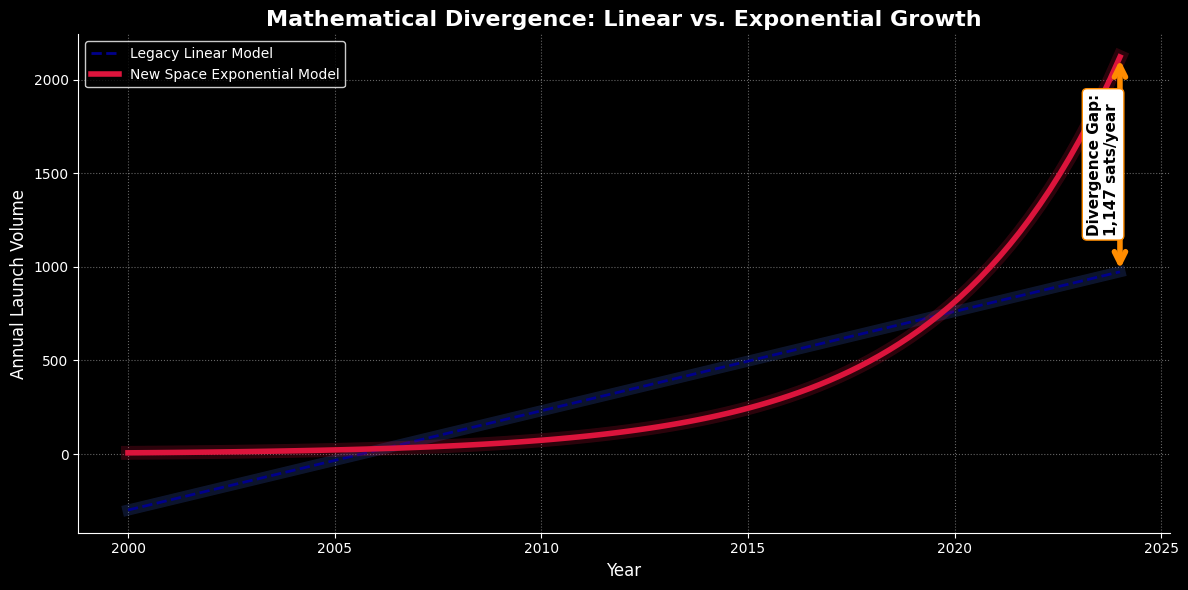

In [10]:
# Define the X-axis range for the audit
x_audit = np.linspace(2000, 2024, 100)

# Calculate Boundary Values
# We see where the models start (2000) and where they end (2024)
lin_2000, exp_2000 = linear_growth(2000, *popt_lin), exponential_growth(2000, *popt_exp)
lin_2024, exp_2024 = linear_growth(2024, *popt_lin), exponential_growth(2024, *popt_exp)

print(f"--- Model Divergence Audit ---")
print(f"Year 2000 Gap: {exp_2000 - lin_2000:,.1f} satellites (Baseline)")
print(f"Year 2024 Gap: {exp_2024 - lin_2024:,.1f} satellites (Risk Surplus)")

# Create the Visualization
plt.figure(figsize=(12, 6))

# Legacy Model (Blue Glow) - The "Safe" Path
plt.plot(x_audit, linear_growth(x_audit, *popt_lin), color='royalblue', alpha=0.2, linewidth=8) 
plt.plot(x_audit, linear_growth(x_audit, *popt_lin), label='Legacy Linear Model', color='darkblue', linestyle='--', linewidth=2)

# New Space Model (Red Glow) - The "Current" Path
plt.plot(x_audit, exponential_growth(x_audit, *popt_exp), color='crimson', alpha=0.2, linewidth=10)
plt.plot(x_audit, exponential_growth(x_audit, *popt_exp), label='New Space Exponential Model', color='crimson', linewidth=4)

# Enhanced Divergence Gap (Orange Arrow)
# Visually connect the two 2024 endpoints
plt.annotate('', xy=(2024, exp_2024), xytext=(2024, lin_2024),
             arrowprops=dict(arrowstyle='<->', color='darkorange', lw=4, mutation_scale=20))

# Label the Gap
gap_value = exp_2024 - lin_2024
plt.text(2023.2, (exp_2024 + lin_2024)/2, f'Divergence Gap:\n{gap_value:,.0f} sats/year', 
         rotation=90, verticalalignment='center', fontweight='bold', fontsize=11, color='black',
         bbox=dict(facecolor='white', edgecolor='darkorange', boxstyle='round,pad=0.3'))

# Formatting
plt.title('Mathematical Divergence: Linear vs. Exponential Growth', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Year', fontsize=12, color='white')
plt.ylabel('Annual Launch Volume', fontsize=12, color='white')
plt.grid(True, which='both', linestyle=':', alpha=0.4)
plt.legend(loc='upper left', frameon=True, facecolor='black', edgecolor='white', labelcolor='white')

sns.despine()
plt.tight_layout()
# Save the "Hero Chart" to the images folder
plt.savefig('../../images/model_divergence_audit.png', dpi=300, bbox_inches='tight')
plt.show()

### **Stage 4.3: Identifying the Acceleration Point (Slope Analysis)**
**The Problem:** Because the "New Space" surge is so aggressive, the exponential model remained consistently above the linear legacy model for the duration of the search window (2000–2024). A simple intersection (where the lines cross) does not exist in this era.

**The Solution:** We shift our focus from **Volume** (where the lines cross) to **Velocity** (where the growth rates cross). By calculating the first derivative (the slope) of both models, we can identify the exact "Acceleration Point."

**The Logic:**
* **Linear Slope ($m$):** Represents the steady, historical cadence of legacy spaceflight.
* **Exponential Slope ($f'(x)$):** Represents the accelerating rate of deployments in the commercial era.
* **The Acceleration Point:** The specific year where the exponential growth rate officially became steeper than the legacy linear trend, signaling a fundamental regime shift in orbital density.

In [11]:
# We retrieve the linear velocity limit we found in Stage 4.1
linear_velocity = popt_lin[0]

# Solve for the Intersection
try:
    # brentq searches for the year (x) where slope_diff(x) == 0
    acceleration_year = brentq(slope_diff, 2000, 2024)
    
    # Calculate the volume at that exact decimal year for context
    sat_count_at_accel = exponential_growth(acceleration_year, *popt_exp)

    # 3. The Intelligence Output
    print(f"--- ACCELERATION EVENT IDENTIFIED ---")
    print(f"Exact Date (Decimal):  {acceleration_year:.4f}")
    print(f"Operational Volume:    {int(sat_count_at_accel)} satellites")
    print(f"Velocity Limit:        {linear_velocity:.2f} sats/year (Legacy Max)")
    print(f"Status:                LIMIT BROKEN")

except Exception as e:
    print(f"CRITICAL: Could not solve for acceleration point. {e}")

--- ACCELERATION EVENT IDENTIFIED ---
Exact Date (Decimal):  2014.5722
Operational Volume:    221 satellites
Velocity Limit:        53.02 sats/year (Legacy Max)
Status:                LIMIT BROKEN


### **Stage 4.3.1: Visualizing the Velocity Shift**
**The Insight:** The chart below visualizes the first derivative (Speed) of both models. The intersection point marks the exact moment the commercial industry began deploying satellites faster than historical legacy trends could predict.

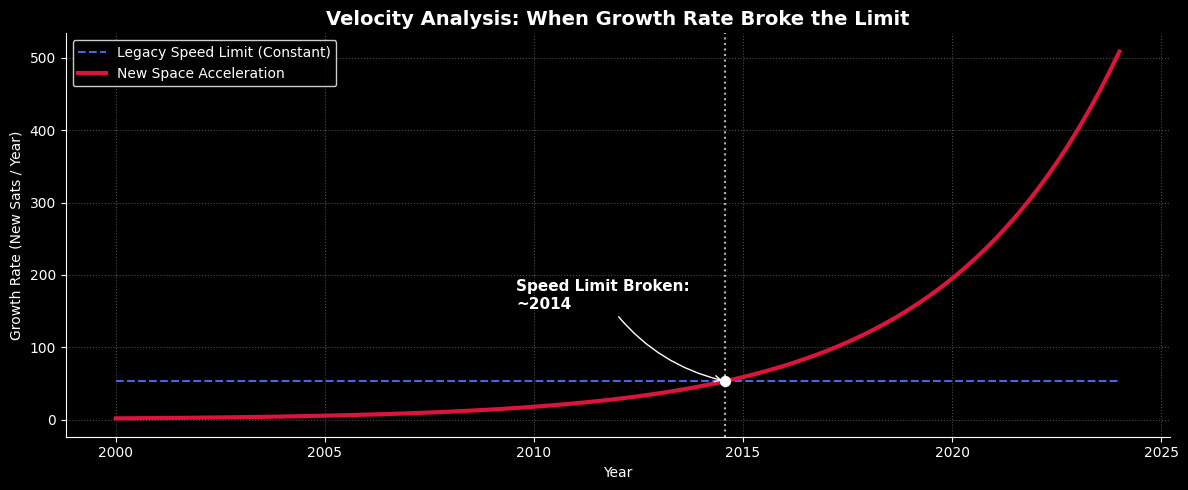

In [12]:
# Create the slope data
x_slope = np.linspace(2000, 2024, 100)

# 'linear_velocity' comes from the previous cell (Stage 4.3)
y_slope_lin = [linear_velocity] * 100 
y_slope_exp = [exponential_slope(x, *popt_exp) for x in x_slope]

plt.figure(figsize=(12, 5))

# Plot the Slopes (Velocity)
plt.plot(x_slope, y_slope_lin, label='Legacy Speed Limit (Constant)', color='royalblue', linestyle='--')
plt.plot(x_slope, y_slope_exp, label='New Space Acceleration', color='crimson', linewidth=3)

# Mark the Acceleration Point
# Changed Black -> White for visibility against Dark Background
plt.axvline(x=acceleration_year, color='white', linestyle=':', alpha=0.7)
plt.scatter([acceleration_year], [linear_velocity], color='white', zorder=5, s=50)

plt.title('Velocity Analysis: When Growth Rate Broke the Limit', fontsize=14, fontweight='bold', color='white')
plt.ylabel('Growth Rate (New Sats / Year)', color='white')
plt.xlabel('Year', color='white')

plt.annotate(f'Speed Limit Broken:\n~{int(acceleration_year)}', 
             xy=(acceleration_year, linear_velocity), 
             xytext=(acceleration_year - 5, linear_velocity + 100),
             arrowprops=dict(facecolor='white', edgecolor='white', arrowstyle='->', connectionstyle="arc3,rad=.2"),
             fontsize=11, color='white', fontweight='bold')

plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
plt.grid(True, linestyle=':', alpha=0.3)
sns.despine()

plt.tight_layout()
plt.show()

### **Stage 4.4: The Strategic Synthesis**
**The Visual Proof:** The chart below combines our observations and models into a single strategic picture.

**Key Elements:**
* **The Pivot:** The vertical line marks the calculated "Acceleration Year"—the moment the industry shifted gears.
* **The Risk Surplus:** The shaded magenta region represents the "Unplanned Mass"—satellites that exist solely because of the exponential shift, creating a debris burden the original orbital safety guidelines were never designed to handle.

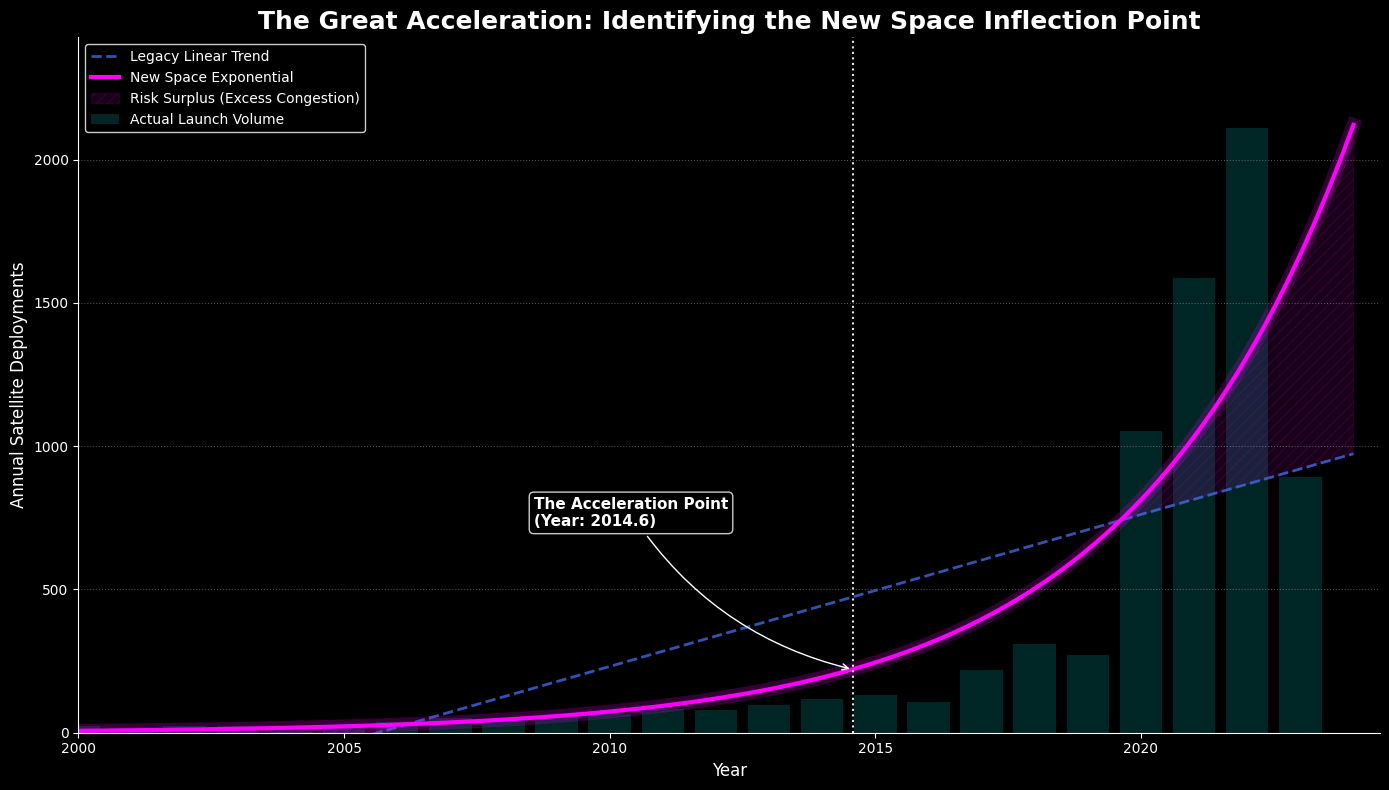

In [13]:
x_fit = np.linspace(2000, 2024, 100)
y_lin_pred = linear_growth(x_fit, *popt_lin)
y_exp_pred = exponential_growth(x_fit, *popt_exp)

plt.figure(figsize=(14, 8))

# The Raw Data (Context)
# We plot the actuals as bars to show the "mass" of the volume
plt.bar(yearly_counts['launch_year'], yearly_counts['satellite_name'], 
        color='cyan', alpha=0.15, label='Actual Launch Volume', width=0.8)

# The Models (The Narrative)
# Legacy Linear (The Road Not Taken)
plt.plot(x_fit, y_lin_pred, label='Legacy Linear Trend', 
         color='royalblue', linestyle='--', linewidth=2, alpha=0.8)

# New Space Exponential (The Reality)
plt.plot(x_fit, y_exp_pred, label='New Space Exponential', 
         color='magenta', linestyle='-', linewidth=3)
# Add a "Glow" effect to the exponential line
plt.plot(x_fit, y_exp_pred, color='magenta', linewidth=10, alpha=0.2)

# The Acceleration Event (The Pivot)
# Vertical line at the calculated year
plt.axvline(x=acceleration_year, color='white', linestyle=':', alpha=0.9, linewidth=1.5)

# Annotation for the Event
plt.annotate(f'The Acceleration Point\n(Year: {acceleration_year:.1f})', 
             xy=(acceleration_year, sat_count_at_accel), 
             xytext=(acceleration_year - 6, sat_count_at_accel + 500),
             arrowprops=dict(facecolor='white', arrowstyle='->', connectionstyle="arc3,rad=.2"),
             fontsize=11, fontweight='bold', color='white', 
             bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3', alpha=0.8))

# The Risk Surplus (The Danger Zone)
# Shade the area where Exponential > Linear
plt.fill_between(x_fit, y_lin_pred, y_exp_pred, 
                 where=(y_exp_pred > y_lin_pred), 
                 color='magenta', alpha=0.1, hatch='///', label='Risk Surplus (Excess Congestion)')

# Formatting & Export
plt.title('The Great Acceleration: Identifying the New Space Inflection Point', fontsize=18, fontweight='bold', color='white')
plt.ylabel('Annual Satellite Deployments', fontsize=12, color='white')
plt.xlabel('Year', fontsize=12, color='white')
plt.xlim(2000, 2024.5)

# Dynamic Y-Limit to keep it tight but readable
plt.ylim(0, yearly_counts['satellite_name'].max() * 1.15)

# Legend Logic
plt.legend(frameon=True, facecolor='black', edgecolor='white', loc='upper left', labelcolor='white')
plt.grid(axis='y', linestyle=':', alpha=0.3)
sns.despine()

plt.tight_layout()

plt.savefig('../../images/great_acceleration.png', dpi=300, bbox_inches='tight')
plt.show()

### **Stage 4.5: Final Metric Validation**
**The Hard Numbers:**
The table below quantifies the "Kessler Delta"—the numerical difference between the predicted legacy environment and the actual commercial reality. These figures represent the **input load** that the debris environment must now absorb.

In [14]:
print(f"{'Metric':<35} | {'Value':<25}")
print("-" * 65)
print(f"{'Acceleration Event (Year)':<35} | {int(acceleration_year)}")
print(f"{'Velocity at Break-Point':<35} | {int(sat_count_at_accel)} sats/year")
print(f"{'Current Output (2024)':<35} | {int(y_exp_pred[-1])} sats/year")
print(f"{'Risk Surplus (Excess Burden)':<35} | {int(y_exp_pred[-1] - y_lin_pred[-1])} satellites")

Metric                              | Value                    
-----------------------------------------------------------------
Acceleration Event (Year)           | 2014
Velocity at Break-Point             | 221 sats/year
Current Output (2024)               | 2120 sats/year
Risk Surplus (Excess Burden)        | 1147 satellites


# Conclusion: The Active Environment
**Status:** The "Input Rate" analysis is complete.

**Findings:**
1.  **Regime Shift:** The orbital environment abandoned Linear Growth in **2014-2015**.
2.  **Velocity:** We are currently operating on an Exponential curve that is doubling the population density at a rate that legacy mitigation guidelines cannot sustain.
3.  **Risk Concentration:** This mass is not evenly distributed; it is concentrating in the **LEO Shell (500-600km)**.

**Next Phase:**
We have quantified the *Active* population. Now we must quantify the *Invisible* one.
The next notebook, **`satcat_cleanup.ipynb`**, will process the full 60,000-object Master Registry to uncover the dead satellites and rocket bodies lurking in the darkness.